## Library import

In [56]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib as mlp
from matplotlib import rcParams
import itertools
import matplotlib.font_manager

## Function

In [57]:
# Degree to Kelvin  
def D2K(val): 
    return val + 273.15 
def K2D(val):
    return val - 273.15

## Constant

In [58]:
# Boltzmann
epsilon = 1.0
sigma = 5.67*10**(-8)

# dew point temp 계산하기 위한 상수 (-45~60도까지 고정)
b = 17.62
c = 243.12

## Set Time Step

In [59]:
# set timestep, duration
t = 10 # [s]   # time step
duration = 168 # [h] #168시간에 대하여 해석

# unit change 
hour_to_sec = 3600
min_to_sec = 60  
day_to_hour = 24

# timestep list
t_list = [t*i for i in range(int(duration*hour_to_sec/t))]

## Boundary Condition

In [60]:
# 이 항목은 변경할 수 있는 조건에 대해 작성

T_oa = []
T_ia = D2K(20)
T_gnd = []
q_alpha = []
T_tv = D2K(5515) # 태양 온도

# Relative Humidity   # 이거 체크해보고 적절한 값으로 수정할 것
RH = 50 # [%]

# View factor
Fsky = 0.5
Fgnd = 1 - Fsky

# Heat transfer coefficient
h_ci = 4  # [W/m2K] (convection heat transfer inside air)
h_co = 15
h_ro = 5.5 # [W/m2K] 모든 계절에 대한 hadiative transfer coefficinet


for i in t_list:
    T_oa.append(D2K(20 + 10*(math.sin(2*math.pi*i/(hour_to_sec*day_to_hour)+hour_to_sec*6))))
    T_gnd.append(D2K(25 + 15*(math.sin(2*math.pi*i/(hour_to_sec*day_to_hour)+hour_to_sec*6))))
    q_alpha.append(0 + 300*(math.sin(2*math.pi*i/(hour_to_sec*day_to_hour)+hour_to_sec*6)))   #q_alpha = I*alpha

for i in range(len(t_list)):
    if q_alpha[i] <= 0:
        q_alpha[i] = 0

In [61]:
len(t_list)

60480

In [62]:
BC = {'T_oa': T_oa,
        'T_gnd': T_gnd,
        'q_alpha': q_alpha,
        'h_co': h_co}
df_BC = pd.DataFrame(BC)

# CSV 파일로 저장
df_BC.to_csv('../data/BC_data.csv', index=False)


## Boundary Condition (변경 X)

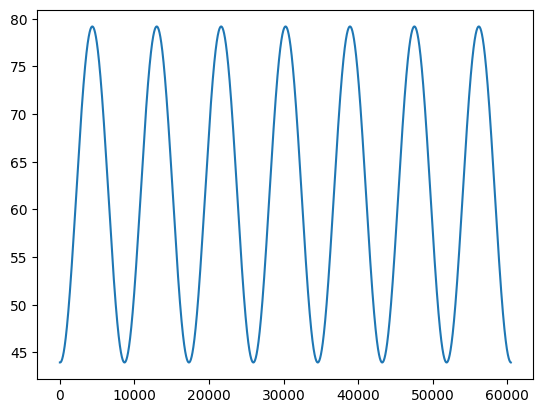

In [63]:
# 이 항목은 개별적으로 변경할 수 없는 조건에 대해 작성

t_dp = [] # 이슬점 온도 [C]
epsilon_sky = [] # Tsky를 구하기 위한 clear sky에 대한 방사율 (could sky에 대한 고려X)
T_sky = [] # [K]

for i in range(len(t_list)):
    t_dp.append(c*(math.log(RH/100)+b*T_oa[i]/(c+T_oa[i])) / (b-math.log(RH/100)+b*T_oa[i]/(c+T_oa[i])))
    epsilon_sky.append(0.711+(0.56*10**(-2))*t_dp[i]+(0.73*10**(-4))*(t_dp[i]**2))
    T_sky.append((epsilon_sky[i]**(1/4))*T_gnd[i])
df_T_sky = pd.DataFrame(T_sky)
plt.plot(K2D(df_T_sky))

## Dictionary

### set material 

In [64]:
# mortar Dense 
mortar_dict =    {"Length"                   : 0.001, # [m]
                    "Thermal_conductivity"   :   1.4, # [W/(m*K)]
                    "Specific_heat"          :  1000, # [J/(Kg*K)]
                    "Density"                :  2200, # [kg/m3] 
                    "Divide"                 :     1, # [None]
                     } 
mortar_dict['Volumetric_heat_capcity'] = mortar_dict["Specific_heat"]*mortar_dict["Density"] # 체적열용량은 따로추가 직접 계산 번거로움 감소

In [65]:
# Concrete Dense 
concrete_dict =    {"Length"                 :  0.02, # [m]
                    "Thermal_conductivity"   :   1.4, # [W/(m*K)]
                    "Specific_heat"          :  1000, # [J/(Kg*K)]
                    "Density"                :  2200, # [kg/m3] 
                    "Divide"                 :     1, # [None]
                     } 
concrete_dict['Volumetric_heat_capcity'] = concrete_dict["Specific_heat"]*concrete_dict["Density"] # 체적열용량은 따로추가 직접 계산 번거로움 감소

# Expanded polystyrene
insulation_1_dict = {"Length"                :  0.05, # [m]
                     "Thermal_conductivity"  :  0.03, # [W/(m*K)]
                     "Specific_heat"         :  1400, # [J/(Kg*K)]
                     "Density"               :    25, # [kg/m3] 
                     "Divide"                :     3, # [None]
                     }  
insulation_1_dict['Volumetric_heat_capcity'] = insulation_1_dict["Specific_heat"]*insulation_1_dict["Density"]

# Expanded polystyrene # 외단열 용 node 2
insulation_2_dict = {"Length"                :  0.05, # [m]
                     "Thermal_conductivity"  :  0.03, # [W/(m*K)]
                     "Specific_heat"         :  1400, # [J/(Kg*K)]
                     "Density"               :    25, # [kg/m3] 
                     "Divide"                :     2, # [None]
                     }  
insulation_2_dict['Volumetric_heat_capcity'] = insulation_2_dict["Specific_heat"]*insulation_2_dict["Density"]

# 미정
insulation_3_dict = {"Length"                :  0.3, # [m]
                     "Thermal_conductivity"  :    2, # [W/(m*K)]
                     "Specific_heat"         : 1000, # [J/(Kg*K)]
                     "Density"               : 1000, # [kg/m3]
                     "Divide"                :    3, # [None] 
                     } 
insulation_3_dict['Volumetric_heat_capcity'] = insulation_3_dict["Specific_heat"]*insulation_3_dict["Density"]

## Set system

In [66]:
M_dict1 = concrete_dict
M_dict2 = concrete_dict
M_dict3 = concrete_dict
M_dict4 = concrete_dict
M_dict5 = concrete_dict

In [67]:
# 총 셀 노드 개수 변수
N = M_dict1["Divide"] + M_dict2["Divide"] + M_dict3["Divide"] + M_dict4["Divide"] + M_dict5["Divide"]
# 초기온도 
initial_temp = D2K(20) 
# --------------------------------------------------------------------------------------------

## 벽체의 열물성을 담은 리스트 정의 [list]
# --------------------------------------------------------------------------------------------
del_x = []
k = []
c = []
rho = []
C = []
K = []
R = [] 
for Midx in [M_dict1, M_dict2, M_dict3, M_dict4, M_dict5]: # Material dict를 넣어줌
    for _ in range(Midx["Divide"]):  # Divide 개수 만큼 복붙
        del_x.append(Midx["Length"]/Midx["Divide"])
        k.append(Midx["Thermal_conductivity"])
        c.append(Midx["Specific_heat"])
        rho.append(Midx["Density"])
        C.append(Midx["Volumetric_heat_capcity"])
        # k/x
        R.append((Midx["Length"]/Midx["Divide"])
                 
                                /Midx["Thermal_conductivity"])
        # x/k
        K.append(Midx["Thermal_conductivity"]
                                /(Midx["Length"]/Midx["Divide"]))
        
# 열전달계수, Tsol 정의 # 온도가 다 초기온도로 들어가있기 때문에 Tridigonal matrix 에서 온도를 업데이트 시키며 같이 업데이트 시켜야함
# --------------------------------------------------------------------------------------------  

x = [del_x[i]/2 for i in range(0, N)] # 셀 절반의 길이

# left

del_x_left = [(del_x[i-1] + del_x[i])/2 for i in range(1, N)] # i=0일 때 i-1 정의 불가
del_x_left.insert(0,del_x[0]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의

R_left =     [(del_x[i-1]/2)/k[i-1]
                +(del_x[i]/2)/k[i]
                for i in range(1,N)]

R_left.insert(0,R[0]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의

K_left = [1/R_left[i] for i in range(N)] # R의 역수로 정의

# right
del_x_right = [(del_x[i] + del_x[i+1])/2 for i in range(N-1)] # i= N일 때 i+1 정의 불가 
del_x_right.append(del_x[N-1]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의 N-1 -> list 에서는 14번째 값

R_right =     [(del_x[i]/2)/k[i]
                +(del_x[i+1]/2)/k[i+1]
                for i in range(N-1)]
R_right.append(R[N-1]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의

K_right = [1/R_right[i] for i in range(N)] # R의 역수로 정의

## Get Temperature

In [68]:
# 온도 정보를 담을 행렬 [matrix]
# --------------------------------------------------------------------------------------------
T = []
T_left = []
T_right = []

# 온도 정보 전부 초기온도로 일단 담기 (해당 매트릭스를 포함하는 리스트들은 모두 T가 업데이트 됨에 따라 업데이트 해줘야함)
for _ in range(len(t_list)):

    T.append([initial_temp for _ in range(N)])
    T_left.append([initial_temp for _ in range(N)])
    T_right.append([initial_temp for _ in range(N)])

# 초기 표면 온도 계산
T_left[0][0] = (h_ro*((q_alpha[0]/h_ro)+Fsky*T_sky[0]+Fgnd*T_gnd[0])+h_co*T_oa[0]+(T[0][0]/R_left[0]))/((1/R_left[0])+h_ro+h_co)


#  T가 업데이트 됨에 따라 업데이트가 필요한 값 T_left[n][0] 대신 T[n][0]으로 계산해준다
    

# q_sol (alpha)


## Tridiagonal matrix
# --------------------------------------------------------------------------------------------

#          | b1 c1  0  0  0 |   | T[n+1][1] |      | g1 |    
#          | a2 b2 c2  0  0 |   | T[n+1][2] |      | g2 |               
#          |  0 a3 b3 c3  0 | . | T[n+1][3] |   =  | g3 |      
#          |  0  0 a4 b4 c4 |   | T[n+1][4] |      | g4 |
#          |  0  0  0 a5 b5 |   | T[n+1][5] |      | g5 |

#                  A{matrix}  *   T{vector}     = B{vector}
#          특정 타임스탭에서 정의했을 때 벡터인 것이지 이것이 누적되어 결국 matrix로 나옴

# a,b,c [list]
a_list = [-t*K_left[i] for i in range(N)]
b_list = [2*del_x[i]*C[i]+t*K_left[i]+t*K_right[i] for i in range(N)]
c = [-t*K_right[i] for i in range(N)]

# A matrix -> 미리 알 수 있는 값
A = np.zeros((N, N)) # 임시로 0값을 가지는 NxN 행렬 만들기

for idx in range(N-1): # A matrix에 a,b,c 리스트 넣어주기

    A[idx+1][idx] = a_list[idx+1]
    A[idx][idx] = b_list[idx]
    A[N-1][N-1] = b_list[N-1]
    A[idx][idx+1] = c[idx]
A_inv = np.linalg.inv(A) # 역행렬 미리 만들어두기
# B matrix -> g 벡터들을 넣어준다 

for n in range(len(t_list)-1): # 타임스탭 for 문 
    B = [] # 타임스탭마다 새롭게 정의해줘야함
    # B list 정의하기 
    for i in range(1,N-1): # node for 문
        B.append([t*K_left[i]*T[n][i-1]+(2*del_x[i]*C[i]-t*K_left[i]-t*K_right[i])*T[n][i]+t*K_right[i]*T[n][i+1]]) # g_i 추가 열벡터로 표현하기 위해 [] 를 씌워줌
    B.insert(0,[2*t*K_left[0]*T_left[n][0]     # 복사, 대류를 고려해서 T_os를 구했기 때문에 그대로 가져다 쓰면 됨
                + (2*del_x[0]*C[0]-t*K_left[0]-t*K_right[0])*T[n][0] 
                + t*K_right[0]*T[n][1]])  
    B.append([t*K_left[N-1]*T[n][N-2]    
                + (2*del_x[N-1]*C[N-1]-t*K_left[N-1]-t*K_right[N-1])*T[n][N-1] 
                + 2*t*K_right[N-1]*T_right[n][N-1]])                     # 그렇게 하기 위해선 Excel로 뽑아 놓았던 데이터를 참고해야함

    # T[n+1] 값 구하고 업데이트 필요한 값들 업데이트 
    for i in range(N): # node for 문 # [0] 은 T가 이중 리스트이기 때문에 리스트를 한 겹 벗겨내기 위함 
        T[n+1][i] = np.dot(A_inv, B)[i][0] # tridiagonal matrix 에서 구한 T[n+1] 값을 다음 계산될 T[n] 리스트 값에 정의
    
    for i in range(1,N):
        T_left[n+1][0] = (h_ro*((q_alpha[n+1]/h_ro)+Fsky*T_sky[n+1]+Fgnd*T_gnd[n+1])+h_co*T_oa[n+1]+(T[n+1][0]/R_left[0]))/((1/R_left[0])+h_ro+h_co)  # 여기 경계 온도들 다 교수님께 답장 받으면 다시 고쳐야 됨
        T_left[n+1][i] = T[n+1][i-1]+(T[n+1][i]-T[n+1][i-1])*(x[i-1]/(x[i-1]+x[i]))
    for i in range(0,N-1):
        T_right[n+1][i] = T[n+1][i]+(T[n+1][i+1]-T[n+1][i])*(x[i]/(x[i]+x[i+1])) 
        T_right[n+1][N-1] = T[n+1][N-1] - (T[n+1][N-1]-T_ia)*R_right[N-1]/(R_right[N-1]+(1/h_ci))


# half time step에 대한 온도를 담을 행렬
T_half = []
T_left_half = []
T_right_half = []
T_oa_half = []

for _ in range(len(t_list)):
    T_half.append([initial_temp for _ in range(N)])
    T_left_half.append([initial_temp for _ in range(N)])
    T_right_half.append([initial_temp for _ in range(N)])
    T_oa_half.append([initial_temp for _ in range(N)])

# 첫 번째 행의 값 -> 0 타임스탭
# 두번째 행의 값 -> 0.5 타임스탭으로 만들기 위해 n+1 항에 대해 정의해줌
for n in range(len(t_list)-1):
    for i in range(0, N):
        T_half[n+1][i] = (T[n][i] + T[n+1][i])/2
        T_left_half[n+1][i] = (T_left[n][i] + T_left[n+1][i])/2
        T_right_half[n+1][i] = (T_right[n][i] + T_right[n+1][i])/2
    
    T_oa_half[n+1] = (T_oa[n] + T_oa[n+1])/2


df_T = K2D(pd.DataFrame(T))
df_T_right = K2D(pd.DataFrame(T_right))
df_T_left = K2D(pd.DataFrame(T_left))
df_T_left_half = K2D(pd.DataFrame(T_left_half))
df_T_half = K2D(pd.DataFrame(T_half))

df_T.to_csv('../data/df_T.csv', index= False)
df_T_right.to_csv('../data/df_T_right.csv', index= False)
df_T_left.to_csv('../data/df_T_left.csv', index= False)


# 업데이트가 필요한 값들 업데이트
# ----- 표면온도를 q1 = q2를 이용해 첫 번째 노드의 온도와 흐르는 열류 q1의 정의로 계산 (T_os 는 열용량이 없으니 열을 그대로 흘려보낸다)
# external |<-------------------------------->| internal
#      o   o    +    +    +    +    +    +    o    o
#   T_BC1 T_os  0    1    2    3    4    5   T_is  T_BC2
#      ---q1---->         q1(T_BC1 to 0)
#          -q2->          q2(T_os  to 0)

### 확인용

In [77]:
q_sky = []
q_gnd = []
q_cv = []
q_cd = []
T_left_sky = []
T_left_sun = []
T_left_gnd = []
T_left_cv = []
T_left_cd = []
q_check = []

q_sky = [0 for _ in range(len(t_list))]
q_gnd = [0 for _ in range(len(t_list))]
q_cv = [0 for _ in range(len(t_list))]
q_cd = [0 for _ in range(len(t_list))]
T_left_sky = [0 for _ in range(len(t_list))]
T_left_sun = [0 for _ in range(len(t_list))]
T_left_gnd = [0 for _ in range(len(t_list))]
T_left_cv = [0 for _ in range(len(t_list))]
T_left_cd = [0 for _ in range(len(t_list))]
q_check = [0 for _ in range(len(t_list))]

for n in range(len(t_list)):
    q_sky[n] = Fsky*h_ro*(T_sky[n]-T_left[n][0])
    q_gnd[n] = Fgnd*h_ro*(T_gnd[n]-T_left[n][0])
    q_cv[n] = h_co*(T_oa[n]-T_left[n][0])
    q_cd[n] = (1/R_left[0])*(T_left[n][0]-T[n][0])
    T_left_sun[n] = q_alpha[n]/((1/R_left[0])+h_ro+h_co)
    T_left_sky[n] = h_ro*(Fsky*T_sky[n])/((1/R_left[0])+h_ro+h_co)
    T_left_gnd[n] = h_ro*(Fgnd*T_gnd[n])/((1/R_left[0])+h_ro+h_co)
    T_left_cv[n] = h_co*T_oa[n]/((1/R_left[0])+h_ro+h_co)
    T_left_cd[n] = (T[n][0]/R_left[0])/((1/R_left[0])+h_ro+h_co)


q_BL = {'q_sky': q_sky,
        'q_gnd': q_gnd,
        'q_cv': q_cv,
        'q_cd' : q_cd,
        'T_left_sun': (T_left_sun),
        'T_left_sky': (T_left_sky),
        'T_left_gnd': (T_left_gnd),
        'T_left_cv': (T_left_cv),
        'T_left_cd': (T_left_cd)}
df_q_BL = pd.DataFrame(q_BL)

# CSV 파일로 저장
df_q_BL.to_csv('../data/q_BL data.csv', index=False)

## Get Heat Flux

In [71]:
# --------------------------------------------------------------------------------------------
# Heat flux

# external |<-------------------------------->| internal space
#          +    +    +    +    +    +    +    +
#         T_BC  0    1    2    3    4    5   T_is
#                --q_in->[2]--q_out-> 
#                       --q-> 
#                  q = [(q_in + q_out)/2]

initial_q = 0

q = []
q_in = []
q_out = []

for _ in range(len(t_list)):
    q.append([initial_q for _ in range(N)])
    q_in.append([initial_q for _ in range(N)])
    q_out.append([initial_q for _ in range(N)])

for n in range(len(t_list)):
    for i in range(1,N):
        q_in[n][i] = (-1)*K_left[i]*(T[n][i] - T[n][i-1])
        q_in[n][0] = K_left[0]*(T_left[n][0] - T[n][0])


    for i in range(0,N-1):
        q_out[n][i] = K_right[i]*(T[n][i] - T[n][i+1])
        q_out[n][N-1] = K_right[N-1]*(T[n][N-1] - T_right[n][N-1])
    
        # q[n][i] = K[i]*(T_left[n][i] - T_left[n][i+1]) # 여기 수정해야 됨
        # q[n][N-1] = K[N-1]*(T_left[n][N-1] - T_right[n][N-1])
        q[n][i] = (q_in[n][i] + q_out[n][i])/2    # 여기 이상함
        q[n][N-1] = (q_in[n][N-1] + q_out[n][N-1])/2

q_half = []
q_in_half = []
q_out_half = []

for _ in range(len(t_list)):
    q_half.append([initial_q for _ in range(N)])
    q_in_half.append([initial_q for _ in range(N)])
    q_out_half.append([initial_q for _ in range(N)])

# 첫 번째 행의 값 -> 0 타임스탭
# 두번째 행의 값 -> 0.5 타임스탭으로 만들기 위해 n+1 항에 대해 정의해줌
for n in range(len(t_list)-1):
    for i in range(0, N):
        q_half[n+1][i] = (q[n][i] + q[n+1][i])/2
        q_in_half[n+1][i] = (q_in[n][i] + q_in[n+1][i])/2
        q_out_half[n+1][i] = (q_out[n][i] + q_out[n+1][i])/2


df_q = (pd.DataFrame(q))
df_q_in = (pd.DataFrame(q_in))
df_q_out = (pd.DataFrame(q_out))

df_q.to_csv('../data/df_q.csv', index= False)
df_q_in.to_csv('../data/df_q_in.csv', index= False)
df_q_out.to_csv('../data/df_q_out.csv', index= False)

## Entropy and Exergy

### system layer

In [72]:
# -------------------------------------------Entropy------------------------------------------------------------------------

## entropy equation
#
#  [Entropy inflow] + [Entropy generation rate] = [Entropy stored rate] + [Entropy outflow] 
# conduction 

entropy = 0 # [W/(m^2*K)]

entropy_if = []  # entropy inflow
entropy_gen = [] # entropy generation
entropy_st = []  # entropy stored
entropy_of = []  # entropy outflow

for _ in range(len(t_list)):
    entropy_if.append([entropy for _ in range(N)])
    entropy_gen.append([entropy for _ in range(N)])
    entropy_st.append([entropy for _ in range(N)])
    entropy_of.append([entropy for _ in range(N)])

# 첫 번째 행의 값 -> 0 타임스탭
# 두번째 행의 값 -> 0.5 타임스탭으로 만들기 위해 n+1 항에 대해 정의해줌 (맨 마지막 행에 대해 0이 나오지 않게)
for n in range(len(t_list)-1):
    for i in range(N):
        entropy_if[n+1][i] = q_in_half[n+1][i]/T_left_half[n+1][i]
        entropy_gen[n+1][i] = (del_x[i]/k[i])*(q_half[n+1][i]/T_half[n+1][i])*(q_half[n+1][i]/T_half[n+1][i])    
        entropy_gen[n+1][i] = del_x[i]*C[i]*((T[n+1][i]-T[n][i])/t*T_half[n+1][i])
        entropy_of[n+1][i] = q_out_half[n+1][i]/T_right_half[n+1][i]

df_entropy_if = (pd.DataFrame(entropy_if))
df_entropy_gen = (pd.DataFrame(entropy_gen))
df_entropy_st = (pd.DataFrame(entropy_st))
df_entropy_of = (pd.DataFrame(entropy_of))

df_entropy_if.to_csv('../data/df_entropy_if.csv', index= False)
df_entropy_gen.to_csv('../data/df_entropy_gen.csv', index= False)
df_entropy_st.to_csv('../data/df_entropy_st.csv', index= False)
df_entropy_of.to_csv('../data/df_entropy_of.csv', index= False)

# -------------------------------------------Exergy------------------------------------------------------------------------

# [exergy inflow] - [exergy consumption] = [stored exergy] + [exergy outflow]

exergy = 0 # [W/(m^2*K)]

exergy_if = []  #exergy inflow
exergy_c = []   #exergy consumption
exergy_st = []  #exergy stored
exergy_of = []  #exergy outflow

for _ in range(len(t_list)):
    exergy_if.append([exergy for _ in range(N)])
    exergy_c.append([exergy for _ in range(N)])
    exergy_st.append([exergy for _ in range(N)])
    exergy_of.append([exergy for _ in range(N)])

# 첫 번째 행의 값 -> 0 타임스탭
# 두번째 행의 값 -> 0.5 타임스탭으로 만들기 위해 n+1 항에 대해 정의해줌 (맨 마지막 행에 대해 0이 나오지 않게)
for n in range(len(t_list)-1):
    for i in range(N):
        exergy_if[n+1][i] = q_in_half[n+1][i]*(1-(T_oa_half[n+1]/T_left_half[n+1][i]))
        exergy_c[n+1][i] = (del_x[i]/k[i])*((T_oa_half[n+1]*q_half[n+1][i]/T_half[n+1][i])*(q_half[n+1][i]/T_half[n+1][i]))
        exergy_st[n+1][i] = del_x[i]*C[i]*(1-(T_oa[n]/T_half[n+1][i]))*((T[n+1][i]-T[n][i])/t)
        exergy_of[n+1][i] = q_out_half[n+1][i]*(1-(T_oa_half[n+1]/T_right_half[n+1][i]))

df_exergy_if = (pd.DataFrame(exergy_if))
df_exergy_c = (pd.DataFrame(exergy_c))
df_exergy_st = (pd.DataFrame(exergy_st))
df_exergy_of = (pd.DataFrame(exergy_of))

df_exergy_if.to_csv('../data/df_exergy_if.csv', index= False)
df_exergy_c.to_csv('../data/df_exergy_c.csv', index= False)
df_exergy_st.to_csv('../data/df_exergy_st.csv', index= False)
df_exergy_of.to_csv('../data/df_exergy_of.csv', index= False)


### Boundary layer

In [73]:
T_sky_half = []
T_gnd_half = []
q_alpha_half = []

T_sky_ini = T_sky[0]

for _ in range(len(t_list)):
    T_sky_half.append([T_sky_ini for _ in range(N)])
    T_gnd_half.append([initial_temp for _ in range(N)])
    q_alpha_half.append([initial_q for _ in range(N)])

for n in range(len(t_list)-1):
    T_sky_half[n+1] = (T_sky[n]+T_sky[n+1])/2
    T_gnd_half[n+1] = (T_gnd[n]+T_gnd[n+1])/2
    q_alpha_half[n+1] = (q_alpha[n]+q_alpha[n+1])/2

# Boundary layer (radiation, convection)
exergy_if_BL = []
exergy_c_BL = []
exergy_of_BL = []
entropy_gen_BL = []

exergy_if_BL = [exergy for _ in range(len(t_list))]
exergy_c_BL = [exergy for _ in range(len(t_list))]
exergy_of_BL = [exergy for _ in range(len(t_list))]
entropy_gen_BL = [entropy for _ in range(len(t_list))]

#for _ in range(len(t_list)):
#    exergy_if_BL.append([exergy for _ in range(1)])
#    exergy_c_BL.append([exergy for _ in range(1)])
#    exergy_of_BL.append([exergy for _ in range(1)])
#    entropy_gen_BL.append([entropy for _ in range(1)])

for n in range(len(t_list)-1):
    entropy_gen_BL[n+1] = (
        (T_tv-T_left_half[n+1][0])/(T_tv*T_left_half[n+1][0])*q_alpha_half[n+1]
        + epsilon*sigma*T_left_half[n+1][0]**3*(1/3+(T_sky_half[n+1]/T_left_half[n+1][0])**3*(T_sky_half[n+1]/T_left_half[n+1][0]-4/3))
        + epsilon*sigma*T_left_half[n+1][0]**3*(1/3+(T_gnd_half[n+1]/T_left_half[n+1][0])**3*(T_gnd_half[n+1]/T_left_half[n+1][0]-4/3))
        + (h_co*(T_left_half[n+1][0]-T_oa_half[n+1]**2))/(T_left_half[n+1][0]*T_oa_half[n+1])
         )
    exergy_if_BL = q_alpha_half[n+1]*(1 - T_oa_half[n+1]/4341)
    exergy_c_BL[n+1] = (
        T_oa_half[n+1]*((T_tv-T_left_half[n+1][0])/(T_tv*T_left_half[n+1][0])*q_alpha_half[n+1])
        + epsilon*sigma*T_left_half[n+1][0]**3*(1/3+(T_sky_half[n+1]/T_left_half[n+1][0])**3*(T_sky_half[n+1]/T_left_half[n+1][0]-4/3))*T_oa_half[n+1] # sky 복사
        + epsilon*sigma*T_left_half[n+1][0]**3*(1/3+(T_gnd_half[n+1]/T_left_half[n+1][0])**3*(T_gnd_half[n+1]/T_left_half[n+1][0]-4/3))*T_oa_half[n+1] # gnd 복사
        + T_oa_half[n+1]*(h_co*(T_left_half[n+1][0]-T_oa_half[n+1])**2)/(T_left_half[n+1][0]*T_oa_half[n+1])
        )
    
df_exergy_c_BL = (pd.DataFrame(exergy_c_BL))

df_exergy_c_BL.to_csv('../data/df_exergy_c_BL.csv', index= False)

In [74]:
exergy_c_sun = []
exergy_c_sky = []
exergy_c_gnd = []
exergy_c_cv = []

exergy_c_sun  = [exergy for _ in range(len(t_list))]
exergy_c_sky = [exergy for _ in range(len(t_list))]
exergy_c_gnd = [exergy for _ in range(len(t_list))]
exergy_c_cv = [entropy for _ in range(len(t_list))]

for n in range(len(t_list)-1):
    exergy_c_sun[n+1] = (T_oa_half[n+1]*((T_tv-T_left_half[n+1][0])/(T_tv*T_left_half[n+1][0])*q_alpha_half[n+1]))
    exergy_c_sky[n+1] = (epsilon*sigma*T_left_half[n+1][0]**3*(1/3+(T_sky_half[n+1]/T_left_half[n+1][0])**3*(T_sky_half[n+1]/T_left_half[n+1][0]-4/3))*T_oa_half[n+1])
    exergy_c_gnd[n+1] = (epsilon*sigma*T_left_half[n+1][0]**3*(1/3+(T_gnd_half[n+1]/T_left_half[n+1][0])**3*(T_gnd_half[n+1]/T_left_half[n+1][0]-4/3))*T_oa_half[n+1])
    exergy_c_cv[n+1] = T_oa_half[n+1]*(h_co*(T_left_half[n+1][0]-T_oa_half[n+1])**2)/(T_left_half[n+1][0]*T_oa_half[n+1])

exergy_c_check = {'exergy_c_sun': exergy_c_sun,
        'exergy_c_sky': exergy_c_sky,
        'exergy_c_gnd': exergy_c_gnd,
        'exergy_c_cv' : exergy_c_cv}
df_exergy_c_check = pd.DataFrame(exergy_c_check)

# CSV 파일로 저장
df_exergy_c_check.to_csv('../data/df_exergy_c_check.csv', index=False)

In [75]:
exergy_c_BL

[0,
 11.57161787528771,
 11.560833660202418,
 11.55030066279555,
 11.540009876740026,
 11.529952698773652,
 11.520120907991041,
 11.51050664631928,
 11.501102400101148,
 11.491900982719404,
 11.482895518195823,
 11.474079425705764,
 11.465446404953315,
 11.456990422352707,
 11.448705697969189,
 11.440586693172222,
 11.432628098959709,
 11.424824824911873,
 11.417171988738787,
 11.40966490638658,
 11.402299082668033,
 11.395070202389451,
 11.38797412194296,
 11.381006861338431,
 11.37416459665025,
 11.367443652853574,
 11.360840497030336,
 11.354351731922055,
 11.347974089810936,
 11.341704426711381,
 11.335539716853065,
 11.329477047441472,
 11.323513613678932,
 11.317646714032982,
 11.31187374573799,
 11.30619220051748,
 11.300599660515505,
 11.295093794425696,
 11.289672353807392,
 11.284333169578847,
 11.279074148678442,
 11.27389327088411,
 11.268788585784689,
 11.263758209892924,
 11.258800323894079,
 11.253913170023207,
 11.24909504956388,
 11.244344320462577,
 11.239659395052252

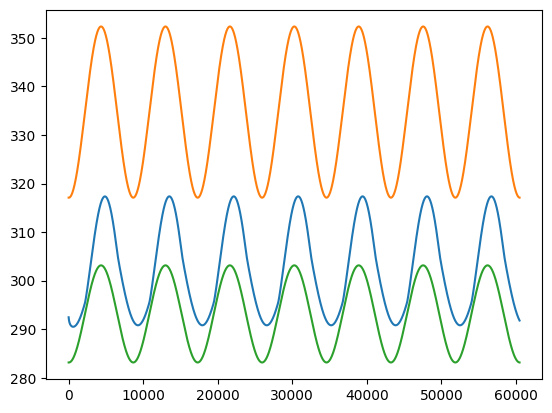

In [187]:
plt.plot(D2K(df_T_left.iloc[:,0]))
plt.plot(T_sky)
plt.plot(T_oa)

In [120]:
T_check = T_sky/D2K(df_T_left.iloc[:,0])

In [121]:
T_check

0        1.082241
1        1.082523
2        1.082746
3        1.082937
4        1.083104
           ...   
60475    1.088892
60476    1.088900
60477    1.088908
60478    1.088916
60479    1.088925
Name: 0, Length: 60480, dtype: float64